# Feature Extraction at Time Series Level for Clustering Nights
The following assumes that we have now selected a set of candidates where the night periods have been preprocessed to ensure that they are consistent and complete, with a consistent start and end time and candidates have been selected based broadly that they maximise the number of complete nights (determined by having zero missing intervals). Generating these features will provide the ability to look at the night periods as a whole, rather than individual intervals, and to cluster them based on their features. This is useful for clustering analysis, where we want to group similar nights together based on their features. The desire is to find patterns in the night periods that can be used to identify different types of nights, such as restful nights, restless nights, or nights with specific patterns of activity. This can help to identify different types of sleep disturbances or other activity that has an impact on the night period, and to provide insights into the underlying states of the patients during these periods.

In [218]:
from src.helper import obfuscate_ids
%load_ext autoreload
%autoreload 2

import pandas as pd
from datetime import time
import matplotlib.pyplot as plt

from src.configurations import ThirtyMinute, FifteenMinute
from src.night_clustering import NightClustering
from src.sample_filter import SampleFilter
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
night_start = time(17, 0)
morning_end = time(11, 0)
sampling = ThirtyMinute()
min_nights = 30
missed_intervals = 1
max_break_run = 1
cob_nan_min = 1
iob_nan_min = 1
sample = SampleFilter(
    night_start=night_start,
    morning_end=morning_end,
    sampling=sampling,
    missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
    cob_nan_min=cob_nan_min,
    iob_nan_min=iob_nan_min
)

df = sample.get_consolidated_df()
sample.return_counts()

2025-06-28 15:22:44.186 | INFO     | src.nights:_calculate_overall_stats:11 - No stats per night have been calculated for 67167655. Returning no output.
2025-06-28 15:23:00.060 | INFO     | src.sample_filter:return_counts:7 - For sample rate of 30 minutes:
  min_nights=30
  missed_intervals=1
2025-06-28 15:23:00.060 | INFO     | src.sample_filter:return_counts:8 - Number of candidates: 17
2025-06-28 15:23:00.063 | INFO     | src.sample_filter:return_counts:9 - Number of nights: 965


(17, 965)

In [59]:
nan_counts = df.isna().sum()
print("Total NaNs per column:")
print(nan_counts)

Total NaNs per column:
iob mean               0
cob mean            1405
bg mean                0
iob min                0
cob min             1405
bg min                 0
iob max                0
cob max             1405
bg max                 0
iob std             4367
cob std             5548
bg std              4367
iob count              0
cob count              0
bg count               0
offset                 0
day                    0
time                   0
night_start_date       0
dtype: int64


There is an oddly significant jump in the number of NaNs in the 'cob mean' column, which is likely due to the way that the COB data is collected and processed. This is a good indication that we need to check the data for missing values and handle them appropriately before proceeding with feature extraction. This has now been addressed in the SampleFilter class, which will ensure that we only include candidates with a minimum number of COB and IOB NaNs. Setting the cob_nan_ratio and iob_nan_ratio will ensure that we have a minimum number of COB and IOB values for each candidate, which will minimise the impact of missing values on the feature extraction process. The following will show the number of NaNs in the COB columns for each candidate, which will help us understand the impact of missing values on the feature extraction process.

In [60]:
cob_nan_min = 0.2
iob_nan_min = 0.05
sample.apply_constraints(missed_intervals=missed_intervals,
    max_break_run= max_break_run,
    min_nights=min_nights,
    cob_nan_min=cob_nan_min,
    iob_nan_min=iob_nan_min)

In [61]:
sample.return_counts()
df = sample.get_consolidated_df()

2025-06-28 15:23:59.086 | INFO     | src.sample_filter:return_counts:7 - For sample rate of 30 minutes:
  min_nights=30
  missed_intervals=1
2025-06-28 15:23:59.086 | INFO     | src.sample_filter:return_counts:8 - Number of candidates: 16
2025-06-28 15:23:59.086 | INFO     | src.sample_filter:return_counts:9 - Number of nights: 922


In [63]:
print('Count of intervals with NaNs for IOB and COB columns')
sample.stats[['total_cob_nans', 'total_iob_nans']].sum()

Count of intervals with NaNs for COB columns, i.e. missing COB data.


total_cob_nans    23
total_iob_nans     0
dtype: int64

In [65]:
# Count number of consecutive NaNs in 'cob mean' column
df_isna = df[df['cob mean'].isna()].copy()
df_reset = df_isna.reset_index().sort_values(['id', 'datetime'])
df_reset['time_diff'] = df_reset.groupby('id')['datetime'].diff().dt.total_seconds() / 60
df_reset.groupby('id')['time_diff'].apply(lambda x: (x == 30).sum())

id
15558575    0
32407882    0
47750728    0
66836068    0
67208817    0
79526193    2
84589080    0
86025410    0
97417885    0
Name: time_diff, dtype: int64

There is only a single instance where these NaNs span greater than 30 minutes, which is the minimum interval between two consecutive COB measurements. This is very minimal and means that we can proceed with imputation of these NaNs in preparation for feature extraction.

In [66]:
df[['cob mean', 'cob min', 'cob max']] = df.groupby('id')[['cob mean', 'cob min', 'cob max']].transform(lambda x: x.interpolate(method='linear'))

Next, we need to select the columns that we want to extract features from. For the clustering of similar nights, we will use ['iob mean', 'cob mean', 'bg mean', 'cob max', 'iob max'] variables and extract additional features from these. The max variables are chosen because they may hold information about the peaks in the night periods, which may be indicative of specific patterns of activity or disturbances. The mean variables are chosen because they provide a summary of the overall activity during the night period, which can be used to identify different types of nights.

In [69]:
df_variables = df[['iob mean', 'cob mean', 'bg mean', 'cob max', 'iob max']].copy().astype(float)

## Experiment 1: Efficient Feature Extraction (Baseline)
The first experiment we will run is using the EfficientFCParameters() that will extract a set of features that are computationally efficient and suitable for clustering analysis. This will provide a good baseline for the feature extraction process and allow us to see how well the clustering works with a smaller set of custom features.

['iob mean', 'cob mean', 'bg mean', 'cob max', 'iob max']
Extracting night-level features using EfficientFCParameters settings...


C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project\src\night_clustering.py:152: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  night_start_date = temp_df['datetime'].dt.date - pd.to_timedelta((hour < night_start_hour).astype(int), unit='D')
Feature Extraction: 100%|██████████| 30/30 [02:11<00:00,  4.38s/it]
C:\.env\master_project\Lib\site-packages\tsfresh\utilities\dataframe_functions.py:198: RuntimeWarning: The columns ['iob max__fft_coefficient__attr_"real"__coeff_19'
 'iob max__fft_coefficient__attr_"real"__coeff_20'
 'iob max__fft_coefficient__attr_"real"__coeff_21' ...
 'cob max__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'cob max__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'cob max__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


Extracted 3885 features for 922 nights.

Night-level features extracted:
                     iob max__variance_larger_than_standard_deviation  \
15558575_2018-04-17                                               1.0   
15558575_2018-04-21                                               1.0   
15558575_2018-04-22                                               1.0   
15558575_2018-04-27                                               1.0   
15558575_2018-04-30                                               1.0   

                     iob max__has_duplicate_max  iob max__has_duplicate_min  \
15558575_2018-04-17                         0.0                         0.0   
15558575_2018-04-21                         0.0                         0.0   
15558575_2018-04-22                         0.0                         0.0   
15558575_2018-04-27                         0.0                         0.0   
15558575_2018-04-30                         0.0                         0.0   

             

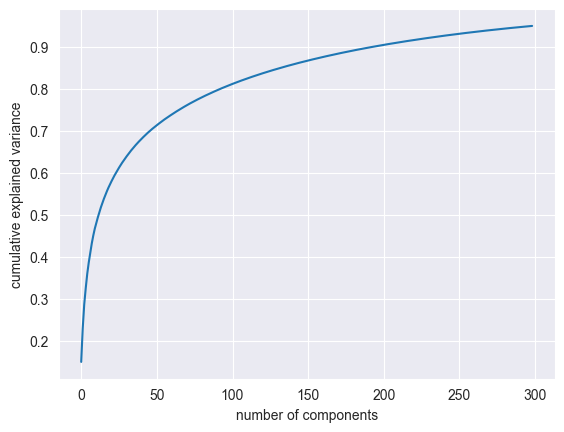

In [70]:
analyser = NightClustering(df=df_variables, feature_settings='efficient')

night_start_hour = 17  # Assuming night starts at 17:00
# Extract Night-Level Features
night_features = analyser.extract_night_level_features(night_start_hour=night_start_hour)  # Finale set uses window of 17:00 to 11:00
print("\nNight-level features extracted:")
print(night_features.head())

# Preprocess Night-Level Features (Scale and PCA)
pca_features = analyser.preprocess_night_features(n_components=0.95)
print("\nPreprocessed PCA features for nights:")
print(pca_features[:5])

# Plot the cumulative explained variance to help decide on the number of components
analyser.plot_pca_cumulative_variance()

The number of features that are selected automatically do not help interpretability, which is important to understanding the patterns behind the clusters. Also, given the number of significant number of features this produces and (even after PCA we reduce to 133 to cover 95% of variance) the elbow curve doesn't have sufficient definition to determine the optimal number of components.

Clustering nights into 2 clusters...
Clustering nights into 3 clusters...
Clustering nights into 4 clusters...
Clustering nights into 5 clusters...
Clustering nights into 6 clusters...


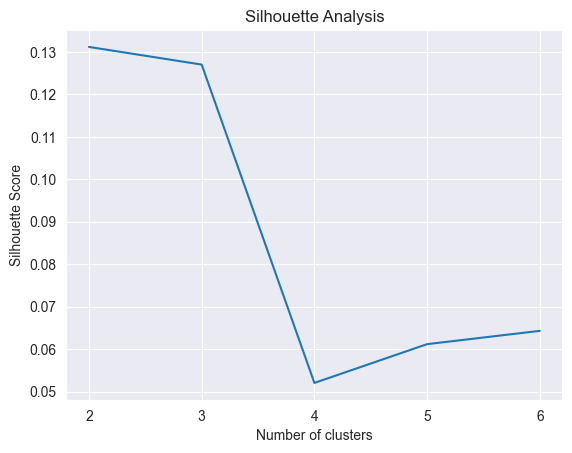

In [71]:
cluster_range = range(2,7)
silhouette_scores = analyser.silhouette_analysis(cluster_range)

Lets look at various cluster sizes to see how they look, comparing their silhouette scores. The Silhouette Coefficient is a measure of how similar an object is to its own cluster compared to other clusters. A higher silhouette score indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. The silhouette score ranges from -1 to 1, where a score close to 1 indicates that the object is well clustered, a score close to 0 indicates that the object is on or very close to the decision boundary between two neighboring clusters, and a negative score indicates that the object may have been assigned to the wrong cluster.

## Experiment 2: Custom Feature Extraction
The following uses the custom features extracted from the data based on knowledge of the patterns we want to identify in the night periods. This will allow us to see how well the clustering works with a smaller set of custom features that are more interpretable and relevant to the patterns we want to identify.

Extracting night-level features using NoneType settings...


C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project\src\night_clustering.py:152: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  column_kind, value_name = None, None
Feature Extraction: 100%|██████████| 30/30 [00:44<00:00,  1.49s/it]


Extracted 68 features for 922 nights.

Night-level features extracted:
                     bg mean__mean  bg mean__variance  bg mean__maximum  \
15558575_2018-04-17     129.076200        1501.694070             237.0   
15558575_2018-04-21     128.550000        2780.735766             284.5   
15558575_2018-04-22     136.810667         800.710010             186.0   
15558575_2018-04-27     134.806028        1752.933933             221.5   
15558575_2018-04-30     175.062443        4676.925621             360.0   

                     bg mean__minimum  bg mean__median  \
15558575_2018-04-17            71.500       122.000000   
15558575_2018-04-21            55.000       124.000000   
15558575_2018-04-22            84.667       145.750000   
15558575_2018-04-27            63.000       126.150002   
15558575_2018-04-30            80.250       157.500000   

                     bg mean__standard_deviation  bg mean__root_mean_square  \
15558575_2018-04-17                    38.751698  

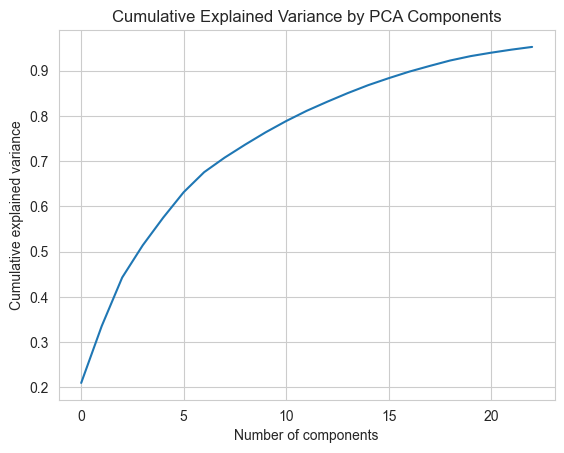

In [222]:
analyser = NightClustering(df=df_variables, feature_settings='custom')
night_features = analyser.extract_night_level_features(night_start_hour=night_start_hour)
print("\nNight-level features extracted:")
print(night_features.head())
pca_features = analyser.preprocess_night_features(n_components=0.95)
analyser.plot_pca_cumulative_variance()

Clustering nights into 2 clusters...
Clustering nights into 3 clusters...
Clustering nights into 4 clusters...
Clustering nights into 5 clusters...
Clustering nights into 6 clusters...


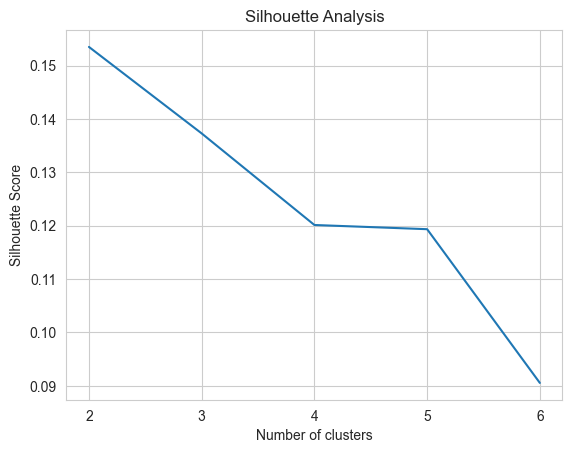

In [191]:
silhouette_scores = analyser.silhouette_analysis(cluster_range)

This is poor again, but not significantly different to the baseline and with notably less features. The custom features are not providing a significant improvement over the efficient features, but they are more interpretable and relevant to the patterns we want to identify. This is a good baseline for the feature extraction process and allows us to see how well the clustering works if we limit the number of components to 2, which is a more manageable number of features to work with and interpret, plus easily visualised in 2D.

Preprocessing night-level features (scaling and PCA)...
PCA reduced dimensions from 66 to 2.
Explained variance: [0.20684251 0.12684751]
Clustering nights into 2 clusters...
Clustering nights into 3 clusters...
Clustering nights into 4 clusters...
Clustering nights into 5 clusters...
Clustering nights into 6 clusters...


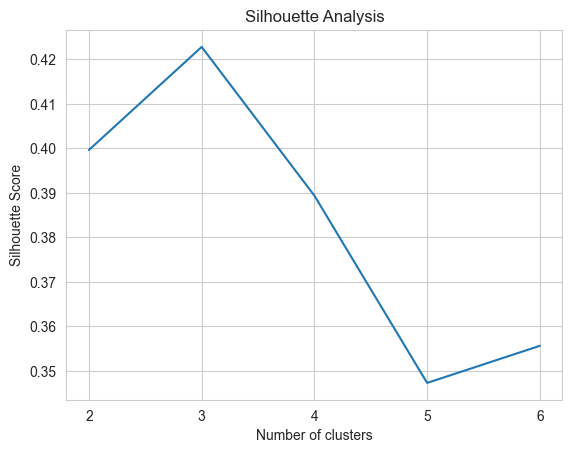

In [192]:
pca_features = analyser.preprocess_night_features(n_components=2)
print(f'Explained variance: {analyser.pca_model.explained_variance_ratio_}')
silhouette_scores = analyser.silhouette_analysis(cluster_range)

Now we have a better silhouette score for 3 clusters, which is a good indication that the clustering is working well. We can now look at the clusters and see how they differ from each other. Let visualise them first, which is easier to do with two components.

Clustering nights into 3 clusters...
Night cluster distribution:
cluster_label
0    510
1    280
2    132
Name: count, dtype: int64
<class 'numpy.ndarray'>


ValueError: 1000 is not in list

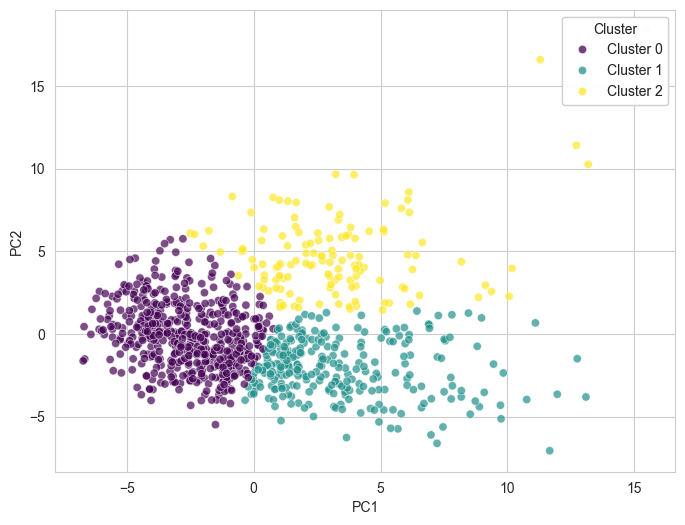

In [193]:
night_clusters = analyser.cluster_nights(n_clusters=3)

The clusters are not perfectly separated and distinction between them isn't clear, as the silhoutte scores would suggest. It is not presently clear why the clustering is showing this pattern, to we need to analyse the clusters further to understand the patterns.

## Centroid Analysis
Now we have established the clusters, we can look at the centroids of each cluster to see what the average feature values are for each cluster. This will help us understand the patterns in the night periods and how they differ between clusters.

In [166]:
# Get characteristics of clusters
cluster_centroids = analyser.get_cluster_centroids()
print("\nCluster Centroids (mean feature values in original scale):")
cluster_centroids.T


Cluster Centroids (mean feature values in original scale):


cluster_label,0,1,2
iob mean__mean,0.723310,1.677868,3.339299
iob mean__variance,1.326711,4.689323,14.720346
iob mean__maximum,3.395400,7.458136,12.739864
iob mean__minimum,-0.669531,-0.349739,-0.893424
iob mean__median,0.477761,0.917425,2.300311
...,...,...,...
iob max__root_mean_square,1.444082,2.972604,5.453259
iob max__first_location_of_maximum,0.406951,0.180045,0.434740
iob max__last_location_of_maximum,0.435115,0.208206,0.462909
iob max__first_location_of_minimum,0.496987,0.596310,0.522932


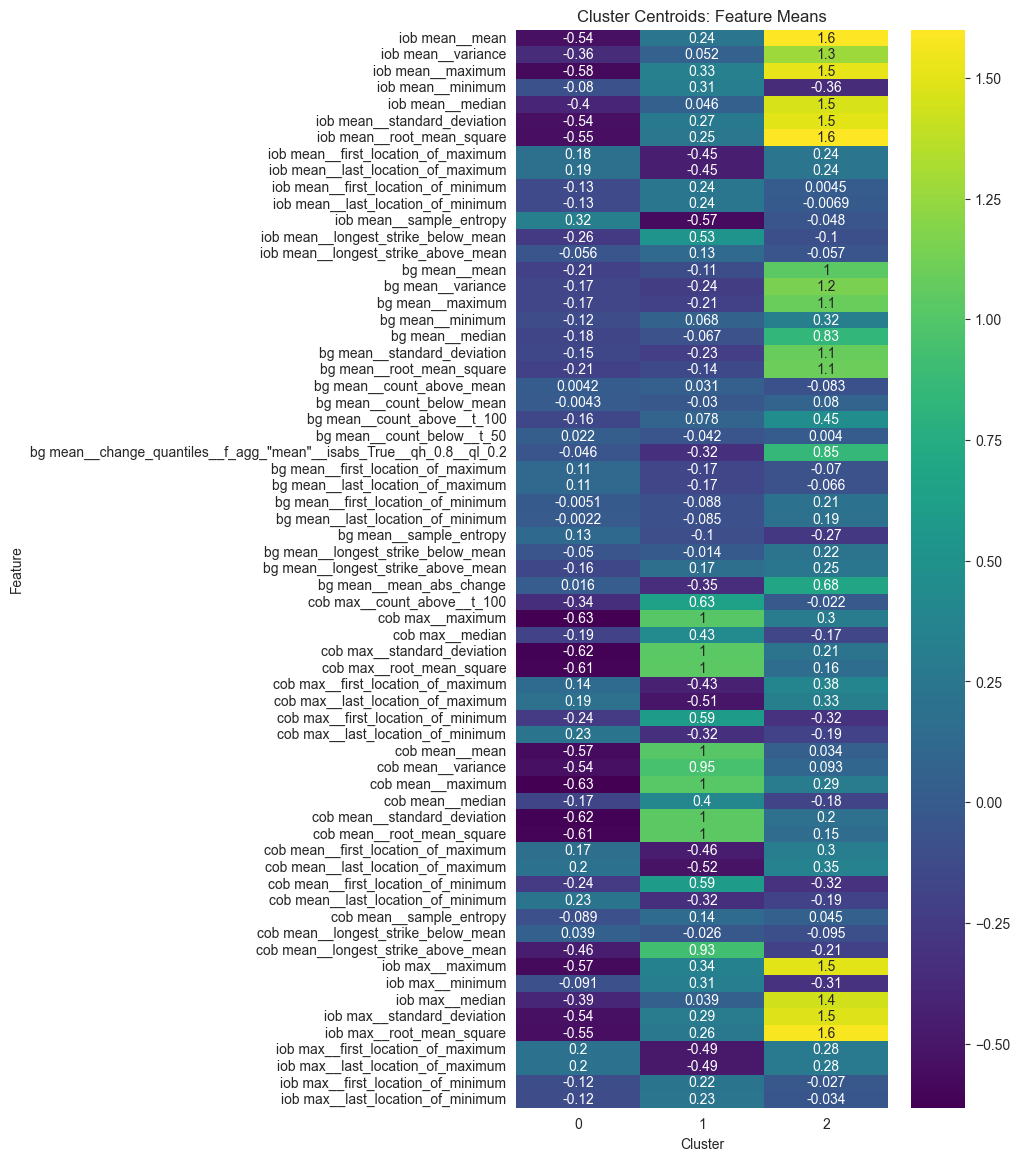

In [167]:
analyser.heatmap_cluster_features()

The heatmap highlights the differences between the clusters, using still scaled values to allow comparison. The largest cluster (cluster 0 at n=510) has relatively low levels of BG and low levels of IOB and COB and low levels of variance in these. Cluster 1 (n=280) sees BG at low to 'standard' levels and higher levels of COB and variance, with higher maxima, but IOB relatively stable with, with low variance. Cluster 2 (n=132) has higher levels of BG, later maximums for BG and IOB variables and low variance as well. This suggests that cluster 2 is a cluster of nights with high levels of activity, cluster 0 is a cluster of nights with low levels of activity, and cluster 1 is a cluster of nights with more stable BG, high levels of COB but stable insulin. This is a good indication that the clustering is working well and that the features are providing useful information about the patterns in the night periods, but we don't yet know how to interpret these clusters in terms of the underlying states of the patients during these periods. We need to look at the individual nights in each cluster to see how they differ from each other and what patterns they exhibit. We'll fist look at the distribution of the clusters to see how they are distributed across the patients.

In [169]:
features_df = analyser.return_dataset_with_clusters().reset_index()
pivot_counts = features_df[['id', 'cluster_label', 'night_start_date']].drop_duplicates().pivot_table(
        index='id',
        columns='cluster_label',
        values='night_start_date',
        aggfunc='count',
        fill_value=0
    )
pivot_percent = pivot_counts.div(pivot_counts.sum(axis=1), axis=0) * 100

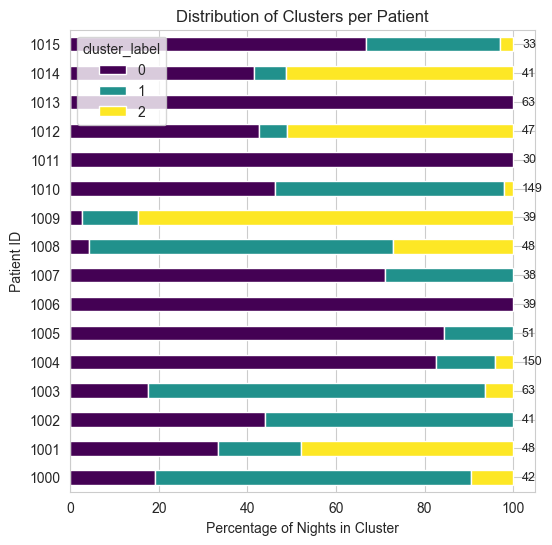

In [179]:
from src.helper import obfuscate_ids
totals = pivot_counts.sum(axis=1)
pivot_percent.index = obfuscate_ids(pivot_percent.index)
ax = pivot_percent.plot(kind='barh',
                   stacked=True,
                   figsize=(6, 6),
                   colormap='viridis',
                   title='Distribution of Clusters per Patient',
                   xlabel='Percentage of Nights in Cluster',
                   ylabel='Patient')

for i, (idx, total) in enumerate(totals.items()):
    ax.text(102, i, f'{total}', va='center', ha='left', fontsize=9)  # 102 puts it just past 100%


plt.show()

The picture is mixed, but shows a clear bias of distributions to single clusters for some patients, which will be due to the clustering. We can measure put some metrics to these distributions using Entropy and Gini Coefficient, which will help us understand the diversity of clusters for each patient. The Entropy is a measure of the uncertainty or randomness in a distribution, while the Gini Coefficient is a measure of inequality in a distribution. A higher Entropy indicates a more diverse distribution, while a lower Gini Coefficient indicates a more equal distribution.

In [180]:
import numpy as np

# For each patient, get the distribution of their nights across clusters
entropy_per_patient = pivot_percent.apply(
    lambda row: -np.nansum((row/100) * np.log2((row/100).replace(0, np.nan))), axis=1
)
# Average entropy across all patients
mean_entropy = entropy_per_patient.mean()
num_clusters = pivot_counts.shape[1]
entropy_per_patient_norm = entropy_per_patient / np.log2(num_clusters)
normalised_mean_entropy = entropy_per_patient_norm.mean()
print(f"Mean entropy of cluster distribution per patient: {mean_entropy:.3f}")
print(f"Normalised mean entropy of cluster distribution per patient: {normalised_mean_entropy:.3f}")

def gini(array):
    array = np.array(array)
    array = array / array.sum()
    diffsum = np.sum(np.abs(np.subtract.outer(array, array)))
    return diffsum / (2 * len(array) * np.sum(array))

gini_per_patient = pivot_counts.apply(gini, axis=1)
mean_gini = gini_per_patient.mean()
print(f"Mean Gini coefficient of cluster distribution per patient: {mean_gini:.3f}")

Mean entropy of cluster distribution per patient: 0.840
Normalised mean entropy of cluster distribution per patient: 0.530
Mean Gini coefficient of cluster distribution per patient: 0.458


The values show that the distribution of clusters is similar to how we have observed in the bar chart, with some patients having a more diverse distribution of clusters than others, resulting in Gini scores showing neither equality or inequality, and entropy scores showing a moderate level of diversity. Now we can consider applying the same analysis to individuals, to see how their own nights cluster.

In [188]:
max_id = entropy_per_patient_norm.idxmax()
min_id = entropy_per_patient_norm.idxmin()
sorted_series = entropy_per_patient_norm.sort_values()
mid_id = sorted_series.index[len(sorted_series) // 2]

In [219]:
# def plot_tsne(analyser, perplexity=30, max_iter=1000, random_state=42):
#     """
#     Plots a t-SNE visualisation of the night-level features, colored by cluster label.
#     Assumes analyser.night_features_df returns a DataFrame with all features and a 'cluster_label' column.
#     """
#     import matplotlib.pyplot as plt
#     import seaborn as sns
#
#     df = analyser.night_features_df.copy()
#     features = df.drop(columns=['cluster_label'])
#     clusters = df['cluster_label']
#
#     # Optionally scale features for t-SNE (recommended)
#
#     features_scaled = StandardScaler().fit_transform(features)
#
#     tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=max_iter, random_state=random_state)
#     tsne_results = tsne.fit_transform(features_scaled)
#     print(tsne_results.shape)
#     plt.figure(figsize=(8, 6))
#     sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=clusters, palette='tab10', alpha=0.7)
#     plt.title('t-SNE Visualization of Night Features by Cluster')
#     plt.xlabel('t-SNE 1')
#     plt.ylabel('t-SNE 2')
#     plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.tight_layout()
#     plt.show()
#
#     return tsne_results

(922, 2)


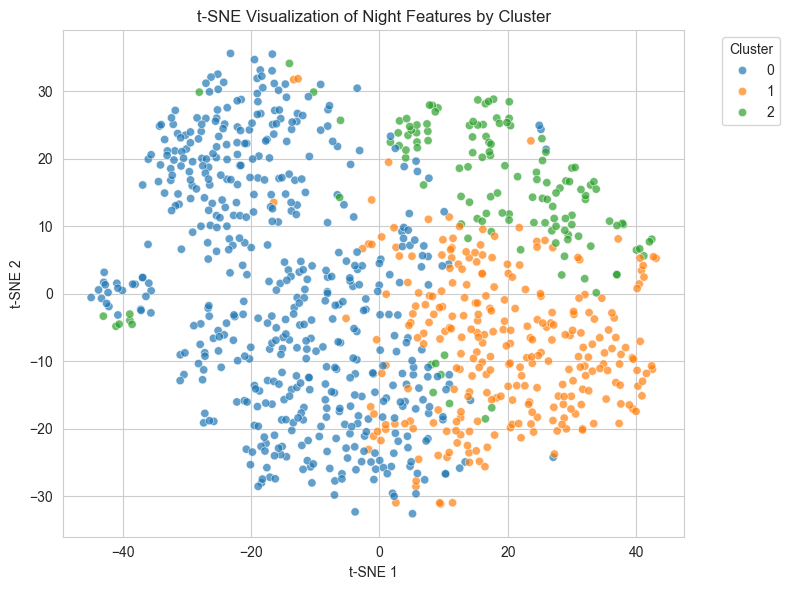

In [220]:
tsne_results = plot_tsne(analyser, perplexity=30, max_iter=3000)


In [238]:
analyser = NightClustering(df=df_variables, feature_settings='custom')
analyser.extract_night_level_features(night_start_hour=night_start_hour)
analyser.preprocess_night_features(n_components=2)

Extracting night-level features using NoneType settings...


C:\Users\ross\OneDrive\Documents\Masters\Project\masters_project\src\night_clustering.py:152: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  column_kind, value_name = None, None
Feature Extraction: 100%|██████████| 30/30 [00:40<00:00,  1.34s/it]


Extracted 68 features for 922 nights.
Preprocessing night-level features (scaling and PCA)...
PCA reduced dimensions from 65 to 2.


array([[ 1.03298296, -2.22253027],
       [ 6.44792428,  1.36997709],
       [ 4.35239697, -2.10064959],
       ...,
       [ 1.66881361, -1.92026205],
       [ 0.1431363 ,  0.72076961],
       [ 2.64657071,  0.73662272]], shape=(922, 2))

Clustering nights into 3 clusters...
Night cluster distribution:
cluster_label
2    523
1    277
0    122
Name: count, dtype: int64


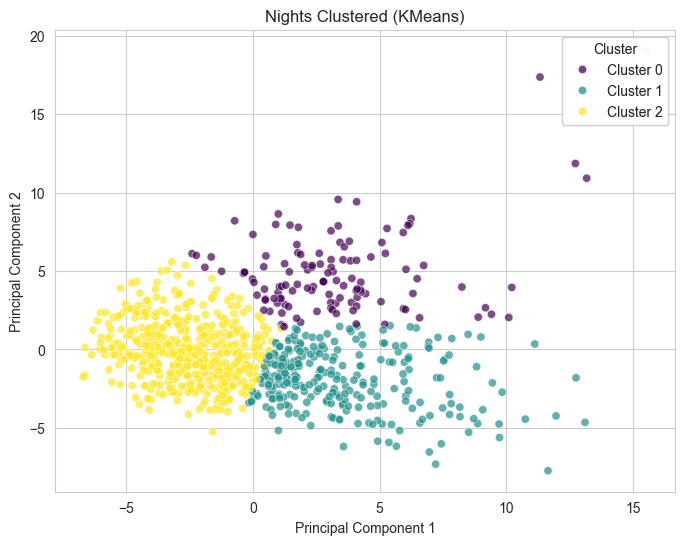

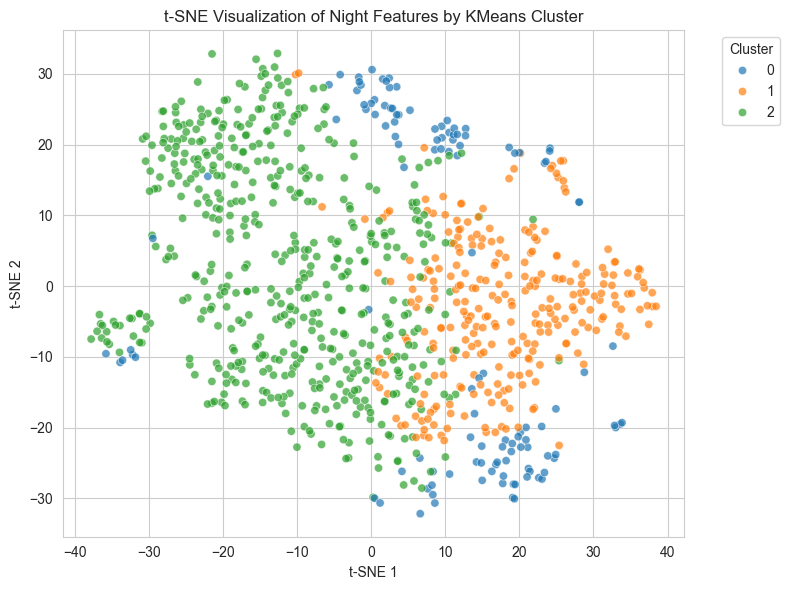

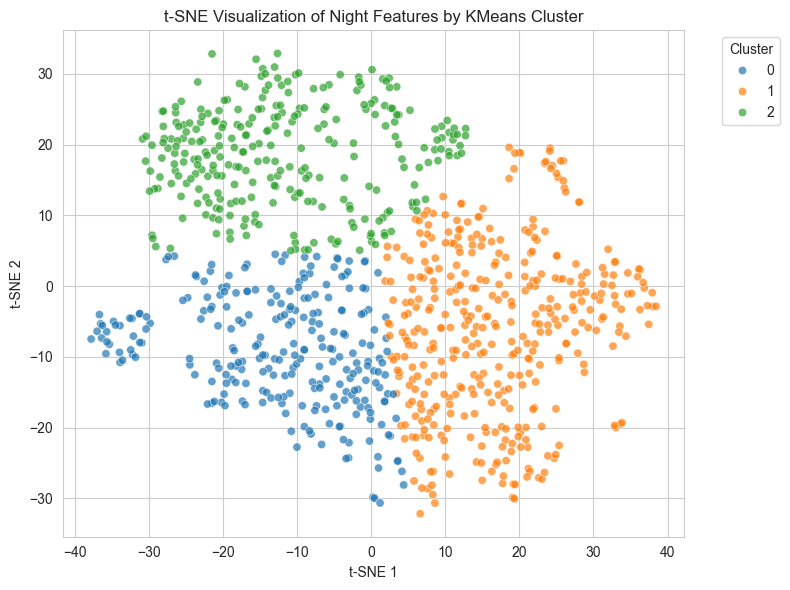

In [239]:
analyser.cluster_nights(n_clusters=3)
analyser.fit_tsne()
analyser.plot_tsne(cluster_type='kmeans')
analyser.clustering_tsne()
analyser.plot_tsne(cluster_type='tsne')